###### Note: 딥러닝을 종단간 기계학습(end-to-end machine learning) 이라고 하는데, 이는 데이터의 입역부터 출력까지 사람의 개입이 이루어지지 않음을 의미한다.

## 손실함수
    일반적으로 평균제곱오차(MSE), 교차엔트로피오차(CEE)를 사용

In [1]:
import numpy as np

In [2]:
# MSE 함수
def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)

# y: 신경망의 소프트맥스 출력값
# t: 정답
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]    # 원핫인코딩, 정답=2
y1 = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]   # 예시1, '2'일 확률이 가장 높다고 추정
y2 = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]   # 예시2, '7'일 확률이 가장 높다고 추정

print(mean_squared_error(np.array(y1), np.array(t)))
print(mean_squared_error(np.array(y2), np.array(t)))

0.09750000000000003
0.5975


In [3]:
# CEE 함수
def _cross_entropy_errror(y, t):
    delta = 1e-7    # y의 0값을 방지하는 작은 값
    return -np.sum(t * np.log(y+delta))

# y: 신경망의 소프트맥스 출력값
# t: 정답
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]    # 원핫인코딩, 정답=2
y1 = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]   # 예시1, '2'일 확률이 가장 높다고 추정
y2 = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]   # 예시2, '7'일 확률이 가장 높다고 추정

print(_cross_entropy_errror(np.array(y1), np.array(t)))
print(_cross_entropy_errror(np.array(y2), np.array(t)))

0.510825457099338
2.302584092994546


    모든 데이터셋을 대상으로 손실함수의 계산은 비효율적 (ex. MNIST 데이터셋은 훈련데이터가 60,000개)
    그러므로, 훈련데이터의 일부만 골라 학습을 진행(mini batch)

In [4]:
from master.dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

print(x_train.shape)
print(t_train.shape)

(60000, 784)
(60000, 10)


In [5]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)    # 무작위로 선택된 인덱스
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

In [6]:
# 배치용 CEE함수
def cross_entropy_error(y, t):
    if y.dim == 1:    # 데이터 하나에 대한 CEE 계산일 경우, 데이터 형상을 변경
        y = y.reshape(1, y.size)
        t = t.resahpe(1, t.size)
        
    bach_size = y.shpae[0]
    return -np.sum(t * np.log(y + 1e-7)) / batch_size

###### Note: 궁극적 목표인 '정확도'라는 지표를 놔두고 '손실함수의 값'이라는 우회적인 방법을 택하는 이유는 '미분'에 역활에 주목하기 때문이다. 최적의 매개변수(가중치와 편향)을 탐색할 때 손실함수의 값을 가능한 한 작게 하는 매개변수를 찾게되는데, 이때 매개변수의 미분(기울기)을 계산하고 그 미분 값을 단서로 매개변수의 값을 서서히 갱신하는 과정을 반복하기 때문이다.    
###### '정확도'를 지표로 삼게 되면 대부분의 장소에서 미분 값이 0이 되어 매개변수를 갱신 할 수 없기 때문입니다. 정확도는 연속적인 변화가 아닌 불연속적인 변화(ex. 32.1%, 34%, 33.7% ...)를 띄는 반면 손실함수는 0.92543, 0.93432 같이 연속적으로 변화하는 것을 관찰 할 수 있다. 따라서 계단함수가 작은 변화가 주는 파장을 불연속성으로 말살하는 것을 이유로 활성화 함수로 사용되지 않는 것과 마찬가지로 '정확도' 또한 지표로써 활용 될 수 없다.

## 미분
    경사법에서는 기울기(경사) 값을 기준으로 나아갈 방향을 정한다.

In [7]:
# 수치미분의 나쁜 구현 예
# 반올림 오차(작은 값이 생략되는 문제), 차분(두 점에서의 함수값들의 차이) 두 가지의 문제점 발생
def _numerical_diff(f, x):
    h = 10e-50
    return (f(x + h) - f(x)) / h

In [8]:
# 두가지 문제점 개선 수치미분 함수
def numerical_diff(f, x):
    h = 1e-4    # 미세한 값으로 10^-4을 사용하면 좋은 결과를 얻을 수 있음
    return (f(x+h) - f(x-h)) / (2*h)

In [9]:
import matplotlib.pyplot as plt

# 예시 함수, y = 0.01x^2 + 0.1x
def func_1(x):
    return 0.01*x**2 + 0.1*x

x = np.arange(0.0, 20.0, 0.1)
y = func_1(x)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.plot(x, y)
plt.show()

<Figure size 640x480 with 1 Axes>

0.1999999999990898
0.2999999999986347


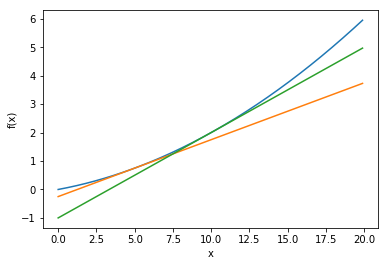

In [10]:
# 접선의 기울기 함수
def tangent_line(f, x):
    d = numerical_diff(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y

x = np.arange(0.0, 20.0, 0.1)
y = func_1(x)

tf1 = tangent_line(func_1, 5)    # x=5 에서의 기울기, 실제 '진정한 미분'값은 2
tf2 = tangent_line(func_1, 10)   # x=10 에서의 기울기, 실제 '진정한 미분'값은 3

plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(x, y)
plt.plot(x, tf1(x))
plt.plot(x, tf2(x))
plt.show()

In [11]:
# 예시 함수, f(x(0), x(1)) = x(0)^2 + x(1)^2
def func_2(x):
    return x[0]**2 + x[1]**2

In [12]:
# x(0)=3, x(1)=4 일때, x(0)에 대한 편미분
def func_tmp1(x0):
    return x0*x0 + 4.0**2.0

numerical_diff(func_tmp1, 3.0)

6.00000000000378

In [13]:
# x(0)=3, x(1)=4 일때, x(1)에 대한 편미분
def func_tmp2(x1):
    return 3.0*2.0 + x1*x1

numerical_diff(func_tmp2, 4.0)

7.999999999999119

## 기울기
    모든 변수의 편미분을 벡터로 정리한 것을 기울기(gradient)라고 한다.

In [14]:
# 기울기 함수
def numerical_gradient(f, x):
    h = 1e-4    # 0.0001
    grad = np.zeros_like(x)    # x와 형상이 같은 배열을 생성
    
    for i in range(x.size):
        tmp_val = x[i]
        
        # f(x+h) 계산
        x[i] = tmp_val + h
        fxh1 = f(x)
        
        # f(x-h) 계산
        x[i] = tmp_val - h
        fxh2 = f(x)
        
        grad[i] = (fxh1 - fxh2) / (2*h)
        x[i] = tmp_val    # 값 복원
        
    return grad

print(numerical_gradient(func_2, np.array([3.0, 4.0])))    # (3, 4)에서의 기울기
print(numerical_gradient(func_2, np.array([0.0, 2.0])))    # (0, 2)에서의 기울기
print(numerical_gradient(func_2, np.array([3.0, 0.0])))    # (3, 0)에서의 기울기

[6. 8.]
[0. 4.]
[6. 0.]


In [15]:
# 경사하강법 함수
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= lr * grad
    return x

init_x = np.array([-3.0, 4.0])
gradient_descent(func_2, init_x=init_x, lr=0.1, step_num=100)

array([-6.11110793e-10,  8.14814391e-10])

In [16]:
# 학습률이 너무 클 때 -> 발산해버림
init_x = np.array([-3.0, 4.0])
gradient_descent(func_2, init_x=init_x, lr=10.0, step_num=100)

array([-2.58983747e+13, -1.29524862e+12])

In [17]:
# 학습률이 너무 작을 때 -> 거의 갱신되지 않은 채 종료
init_x = np.array([-3.0, 4.0])
gradient_descent(func_2, init_x=init_x, lr=1e-10, step_num=100)

array([-2.99999994,  3.99999992])

In [18]:
from master.common.functions import softmax, cross_entropy_error
from master.common.gradient import numerical_gradient


# 신경망에서의 기울기
class SimpleNet:
    def __init__(self):
        self.W = np.random.randn(2, 3)

    def predict(self, x):
        return np.dot(x, self.W)

    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)

        return loss
    
net = SimpleNet()
print(net.W)

[[-1.31534148  0.1123139   0.95479542]
 [ 0.14868539  1.03816883 -0.73029222]]


In [19]:
x = np.array([0.6, 0.9])
p = net.predict(x)
print(p)
print(np.argmax(p))    # 최댓값의 인덱스

[-0.65538804  1.00174029 -0.08438574]
1


In [20]:
t = np.array([0, 0, 1])    # 정답 레이블
print(net.loss(x, t))

1.5102209236683508


In [21]:
# 기울기 산출
dw = numerical_gradient(lambda w: net.loss(x, t), net.W)
print(dw)

[[ 0.07486643  0.39261672 -0.46748314]
 [ 0.11229964  0.58892507 -0.70122471]]


## 학습 알고리즘 구현
    손글씨 숫자를 학습하는 신경망 구현
    2층 신경망(은닉층이 1층)을 대상으로 MNIST 데이터셋 사용

In [22]:
from master.common.functions import *
from master.common.gradient import numerical_gradient


class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x: 입력 데이터, t: 출력 데이터
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x: 입력 데이터, t: 출력 데이터
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        dz1 = np.dot(dy, W2.T)
        da1 = sigmoid_grad(a1) * dz1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis=0)

        return grads
    
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
print(net.params['W1'].shape)
print(net.params['b1'].shape)
print(net.params['W2'].shape)
print(net.params['b2'].shape)

(784, 100)
(100,)
(100, 10)
(10,)


train acc, test acc | 0.09871666666666666, 0.098
train acc, test acc | 0.7733333333333333, 0.781
train acc, test acc | 0.8757833333333334, 0.8814
train acc, test acc | 0.8991666666666667, 0.9019
train acc, test acc | 0.9084, 0.9101
train acc, test acc | 0.91485, 0.9171
train acc, test acc | 0.91925, 0.923
train acc, test acc | 0.9232166666666667, 0.9257
train acc, test acc | 0.9269666666666667, 0.9292
train acc, test acc | 0.9309166666666666, 0.9325
train acc, test acc | 0.93335, 0.9348
train acc, test acc | 0.9354166666666667, 0.9348
train acc, test acc | 0.9378833333333333, 0.9369
train acc, test acc | 0.9406333333333333, 0.9402
train acc, test acc | 0.9424833333333333, 0.9404
train acc, test acc | 0.945, 0.9418
train acc, test acc | 0.9460333333333333, 0.9432


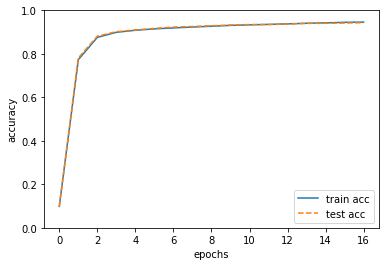

In [23]:
from master.dataset.mnist import load_mnist


(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼파라미터
iters_num = 10000   # 반복 횟수
train_size = x_train.shape[0]
batch_size = 100    # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    grad = network.gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))


# 시각화
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()